# Podklady ke 3. a 4. přednášce - paraxial approximation
Zakladní konstanty + načtení balíčku, které se budou používat pri výpočtech

In [1]:
qe = 1.602e-19; #Elementarni naboj
me = 9.109e-31; #Hmotnost elektronu
c = 299792458; #Rychlost svetla
eta = sqrt(qe/2/me)
using Plots #Balicek pro grafy
using DifferentialEquations # Balicek pro vypocet diferencialnich rovnic
using SpecialFunctions # Specialni funkce
#using ForwardDiff # Derivace funkci
using PolyChaos #Balicek pro vypocet hermiteovych polynomu
using Roots # Balicek pro nalezeni korenu funkce
using LaTeXStrings # Latex v grafech

Funkce pro derivace error funkce
$$erf^{(n)}(x) = \frac{2(-1)^{(n-1)}}{\sqrt{\pi}}H_{n-1}(x)\exp(-x^2)\,,\qquad n>0$$
$H_n$ Hermiteovy polynomy - viz. Wikipedia

In [2]:
hrca,hrcb = rm_hermite(100) #Hermite recurence coefficients (physical monimial)
Hn = (n,x) -> 2^n*PolyChaos.evaluate(n,x,hrca,hrcb) #Hermite polynomial of n-th order
function dnerf(n::Int64,x::Float64) #n stupen derivace n>=0, x - bod v nemz funci pocitame 
    if n==0 #Nulta derivace se musi implementovat zvlast
        return erf(x) 
    else
        return 2*(-1)^(n-1)/sqrt(pi)*Hn(n-1,x)*exp(-x^2);
    end
end
;

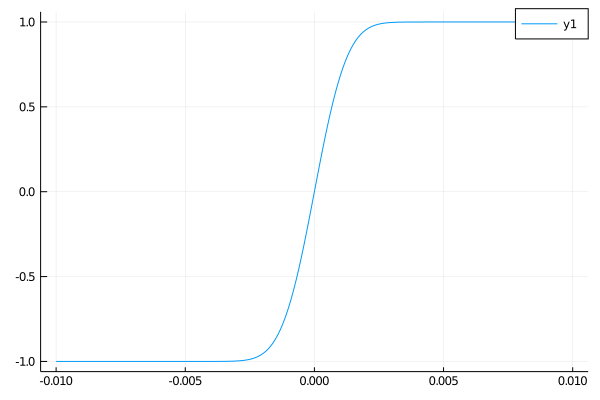

In [3]:
#Plot error funkce, pripadne jejich derivaci, staci zmenit prvni argument dnerf
z1 = (-1:0.01:1)*1e-2
sigma=1e-3
plot(z1,dnerf.(0,z1/(sqrt(2)*sigma)))

## Pole v systému
Použijeme jednoduchou aproximaci magnetického pole Gausovkou
$$B(z)=B_m\exp\left(-\frac{z^2}{s_B^2}\right)$$
pro výpočet derivaci využijeme derivaci error funkce:
$$\exp(-z^2) = \frac{\pi}2\mathrm{erf}^{\prime}(z)$$
tedy 
$$B^{(n)}(z) = B_m\frac{d^n}{dz^n}\exp\left(-\frac{z^2}{s_B^2}\right)=\frac{\sqrt{\pi}}{2s_B^n}\mathrm{erf}^{(n+1)}(\frac z{s_B})$$



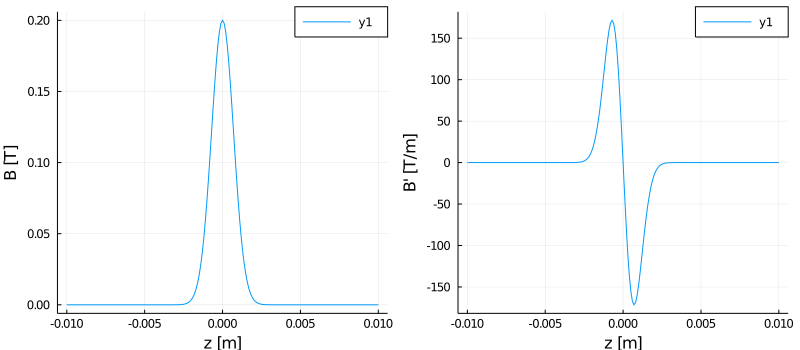

In [4]:
# Function for Gaussian field n=stupen derivace, z - bod ve kterem funci pocitam, 
# Bm - maxumum osoveho pole, sB - parametr urcujici sirku Gausovky
dnB = (n,z,Bm,sB) -> Bm/2*sqrt(pi)/sB^n*dnerf(n+1,z/sB)
z1 = (-1:0.01:1)*1e-2
p=Any[]
Bm=0.2;sB=1e-3
push!(p,plot(z1,dnB.(0,z1,Bm,sB),xlabel="z [m]",ylabel="B [T]"))
push!(p,plot(z1,dnB.(1,z1,Bm,sB),xlabel="z [m]",ylabel="B' [T/m]"))
plot(p...,layout=(1,2),size=(800,350))

Pro elektrostatickou čočku použijeme jednoduché error funkce, Budeme uvažovat tří elektrodovou elektrostatickou cocku, jejich potencial je ve vektoru V. Uvazujeme hladky prechod pomoci error funkce
$$\Phi = \frac 12(\mathrm{erf}((z-z1)/s)+1)(V[2]-V[1])+\frac 12(\mathrm{erf}((z-z2)/s)+1)(V[3]-V[2])+V[1]$$

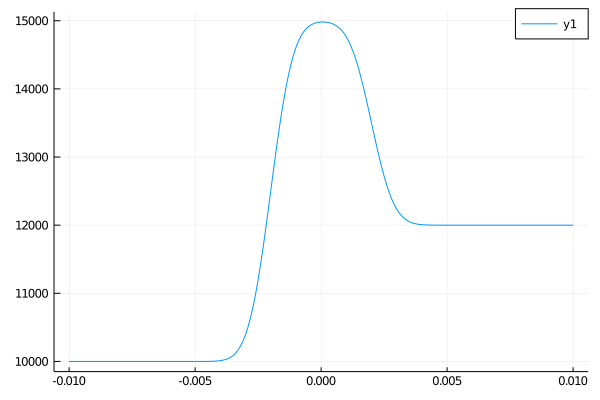

In [5]:
ze=[-2,2]*1e-3 # z1 a z2 - stredy mezer mezi elektrodami ...
s1=1.0e-3; # Rychlost prechodu
function dPhiV(n::Int64,z::Float64,V::Array{Float64,1})
    if n==0 
        dP = (dnerf(n,(z-ze[1])/s1)+1)/2/s1^n*(V[2]-V[1])+(dnerf(n,(z-ze[2])/s1)+1)/2/s1^n*(V[3]-V[2]) +V[1]
    else
        dP = (dnerf(n,(z-ze[1])/s1))/2/s1^n*(V[2]-V[1])+(dnerf(n,(z-ze[2])/s1))/2/s1^n*(V[3]-V[2])
    end
    return dP
end
#Plot osoveho potencialu, pripadne jeho derivaci
dPhi(n,z) = dPhiV(n,z,[1e4; 1.5e4; 1.2e4])
plot(z1,dPhi.(0,z1))

## Paraxiální rovnice trajektorie
Paraxiální rovnice trajektorie ma tvar:
\begin{align}
&x^{\prime\prime}+\frac{\gamma\Phi^{\prime}}{2\Phi^{*}}x^{\prime}+\frac{\gamma\Phi^{\prime\prime}}{4\Phi^*}x+\frac{\eta B}{\sqrt{\Phi^*}}y^{\prime}+\frac{\eta B^{\prime}}{2\sqrt{\Phi^*}}y=0\\
&y^{\prime\prime}+\frac{\gamma\Phi^{\prime}}{2\Phi^{*}}y^{\prime}+\frac{\gamma\Phi^{\prime\prime}}{4\Phi^*}y-\frac{\eta B}{\sqrt{\Phi^*}}x^{\prime}-\frac{\eta B^{\prime}}{2\sqrt{\Phi^*}}x=0
\end{align}
Pro přepsáni do kodu je nutné přejít do soustavy 4 diferencialnich rovnic 1. radu
\begin{align}
x^{\prime} &= dx\\
y^{\prime} &= dy\\
dx^{\prime} &= -\frac{\gamma\Phi^{\prime}}{2\Phi^{*}}dx-\frac{\gamma\Phi^{\prime\prime}}{4\Phi^*}x-\frac{\eta B}{\sqrt{\Phi^*}}dy-\frac{\eta B^{\prime}}{2\sqrt{\Phi^*}}y\\
dy^{\prime}&=-\frac{\gamma\Phi^{\prime}}{2\Phi^{*}}dy-\frac{\gamma\Phi^{\prime\prime}}{4\Phi^*}y+\frac{\eta B}{\sqrt{\Phi^*}}dx+\frac{\eta B^{\prime}}{2\sqrt{\Phi^*}}x
\end{align}


In [13]:
dPhi(n,z) = dPhiV(n,z,[10000.0,10000.0,10000.0]);
dBax(n,z) = dnB(n,z,0.3,1e-3);
Phir(Phi) = Phi*(1+qe*Phi/(2*me*c^2))
#dBax(n,z) = 0.0;
function f(u,p,z)
    Ph = dPhi(0,z); dPh = dPhi(1,z); d2Ph = dPhi(2,z)
    Phr = Phir(Ph)
    B = dBax(0,z); dB = dBax(1,z)
    du = zeros(Float64,4)
    du[1] = u[3]
    du[2] = u[4]
    du[3] = -dPh/(2*Phr)*u[3]-d2Ph/(4*Phr)*u[1]-eta*B/sqrt(Phr)*u[4]-eta*dB/(2*sqrt(Phr))*u[2]
    du[4] = -dPh/(2*Phr)*u[4]-d2Ph/(4*Phr)*u[2]+eta*B/sqrt(Phr)*u[3]+eta*dB/(2*sqrt(Phr))*u[1]
    return du
end


f (generic function with 1 method)

zobrazime nekolik paprsku
a) pomoci primeho vypoctu (Vypocet paraxialni rovnice pro kazdou pocatecni podminku zvlast)

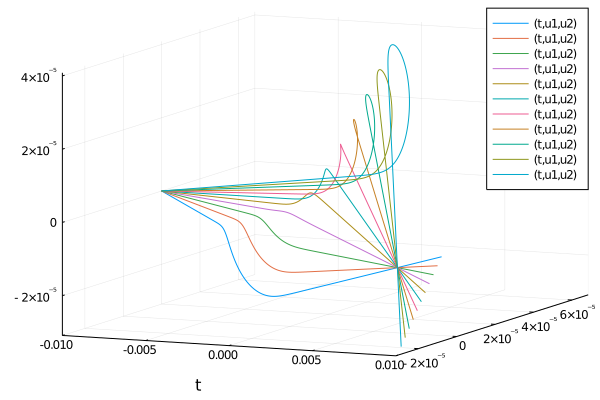

In [14]:
thx=(-1:0.2:1)*5e-3;
zspan = (-1.0e-2,1.0e-2)
x0=2e-5; y0=0;
p=plot()
for i=1:length(thx)
    u0 = [x0,y0,thx[i],0]
    prob = ODEProblem(f,u0,zspan)
    sol = solve(prob,Tsit5(),reltol=1e-10,abstol=1e-12)
    plot!(p,sol,vars=(0,1,2))
end
plot(p)

b) pomoci linearni kombinace reseni. Vsechny řešení lineární diferenciální rovnice tvoří vektorový prostor. Jako bazi zvolíme řešení:
\begin{align}
\vec q_x: \vec q_x(z_o) = [1,0],\, \vec g_x^{\prime}(z_o) = [0,0]\\
\vec q_y: \vec q_y(z_o) = [0,1],\, \vec g_y^{\prime}(z_o) = [0,0]\\
\vec h_x: \vec q_x(z_o) = [0,0],\, \vec h_x^{\prime}(z_o) = [1,0]\\
\vec h_y: \vec h_y(z_o) = [0,0],\, \vec h_y^{\prime}(z_o) = [0,1]
\end{align}

In [15]:
u0=[1,0,0,0]
prob = ODEProblem(f,u0,zspan)
solgx = solve(prob,Tsit5(),reltol=1e-10,abstol=1e-12);
u0=[0,1,0,0]
prob = ODEProblem(f,u0,zspan)
solgy = solve(prob,Tsit5(),reltol=1e-10,abstol=1e-12);
u0=[0,0,1,0]
prob = ODEProblem(f,u0,zspan)
solhx = solve(prob,Tsit5(),reltol=1e-10,abstol=1e-12);
u0=[0,0,0,1]
prob = ODEProblem(f,u0,zspan)
solhy = solve(prob,Tsit5(),reltol=1e-10,abstol=1e-12);


Je vyhodné přejít do komplexních souřadnic $w = x+\mathrm{i}y$, $\bar w = x-\mathrm{i}y$

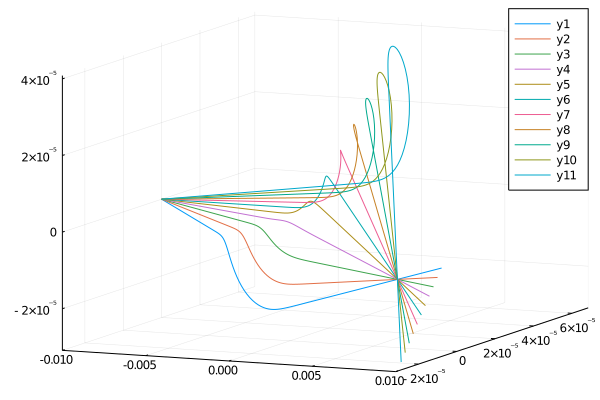

In [16]:
z1 = -0.01:0.0001:0.01
p=plot();
w = (z,wo,dwo) -> sum((real(wo)*solgx(z) + imag(wo)*solgy(z) + real(dwo)*solhx(z) + imag(dwo)*solhy(z))[1:2].*
    [1;1im])
for i=1:length(thx)
    w1 = w.(z1,x0+1im*y0,thx[i])
    plot!(p,z1,real(w1),imag(w1))
end
plot(p)
xlims!((-0.01,0.01))

Rotace svazku v laboratornich souradnicich
$$\theta(z) = \int\limits_{z_o}^z\frac{\eta^2B(z)}{2\Phi^{*\frac12}}\mathrm{d} z$$

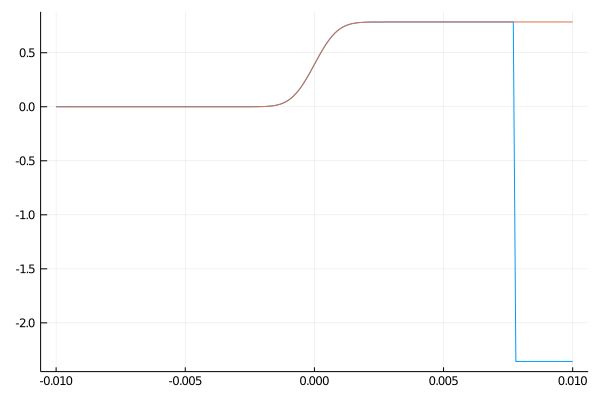

In [19]:
# Integral pocitame pomoci reseni diferencialni rovnice (neni to moc efektivni ...)
prob3=ODEProblem((u,p,z)->eta*dBax(0,z)/(2*sqrt(Phir(dPhi(0,z)))),0.0,(-0.01,0.01))
thr = solve(prob3,Tsit5(),reltol=1e-8,abstol=1e-10);

plot(z1,angle.(w.(z1,0,1e-3)),legend=false) #Vypocet rotace z trajektorii
plot!(z1,thr.(z1),legend=false) #Vypoctena rotace (behem integrace par. rovnice)

Prechod do rotacnich soradnic

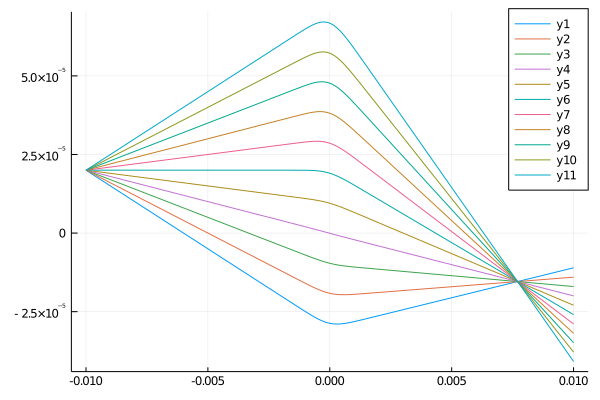

In [20]:
p=plot()
for i=1:length(thx)
    plot!(p,z1,real(w.(z1,x0,thx[i]).*exp.(-1im*thr.(z1))))
end
plot(p)

## Paraxialni aproximace v rotačních souřadnicích - magnetická čočka
\begin{align}
u^{\prime\prime} + \frac{\gamma\Phi^{\prime}}{2\Phi^*}u^{\prime}+\frac{\gamma\Phi^{\prime\prime}+\eta^2B^2}{4\Phi^*}u=0
\end{align}
V pripadě čistě magnetické čočky dostaneme
\begin{align}
u^{\prime\prime} +\frac{\eta^2B^2}{4\Phi^*}u=0
\end{align}
Pro osové magnetické pole zvolíme jednoduchou aproximaci gausovkou $B(z) = B_{max}\exp(-z^2/s_B^2)$ a rovnici trajektorie převedem na dvě ODE prvního řádu
\begin{align}
u^{\prime}&=du\\
du^{\prime}&=-\frac{\eta^2B(z)}{4\Phi^*}u
\end{align}
$B_{max} = 0.3T$ a $\Phi=8\,\rm keV$

In [22]:
Bm =0.3;sB = 1e-3
Bax(z) = dnB(0,z,Bm,sB);Ph = 8000; Phr = Ph*(1+qe*Ph/(2*me*c^2))
f2(u,p,z) = [u[2],-eta^2*Bax(z)^2/(4*Phr)*u[1]];

Jako bázi vektoru řešení parxiálni rovnice zvolíme řešení $g(z): g(z_o)=1,g^{\prime}(z_o)=0$, $h(z): h(z_o)=0,h^{\prime}(z_o)=1$. Pozice predmětu $z_o = -0.01\,\rm m$. Libovolný poprsek je pak dán polohou a směrnicí v předmětu: 
$$u(z) = u_og(z) + u_o^{\prime} h(z)$$
a jeho směrnice
$$u^{\prime}(z) = u_og^{\prime}(z) + u_o^{\prime} h^{\prime}(z)$$

In [23]:
zo = -0.01;
zspan = (-1.0e-2,2.0e-2) #Hranice integrace
u0=[1,0] #Pocatecni podminka pro trajektorii g
#Vypocet trajektorie g
prob2 = ODEProblem(f2,u0,zspan)
solg = solve(prob2,Tsit5(),reltol=1e-8,abstol=1e-10); 
u0 = [0,1]#Pocatecni podminky pro trajektorii h
#Vypocet trajektorie h
prob2 = ODEProblem(f2,u0,zspan)
solh = solve(prob2,Tsit5(),reltol=1e-8,abstol=1e-10);
h = z->solh(z)[1] #funkce trajektorie h
dh = z->solh(z)[2] #funkce trajektorie h
g = z->solg(z)[1] #funkce trajektorie g
dg = z->solg(z)[2] #funkce trajektorie g

#25 (generic function with 1 method)

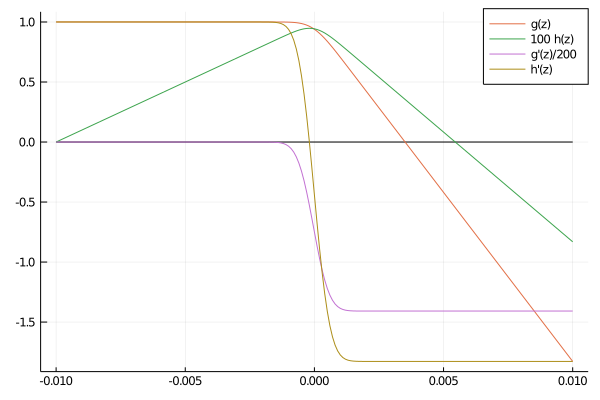

In [24]:
#Plot paraxialnich trajektorii a jejich derivaci 
#(je treba je naskalovat aby se vlezly do jednoho grafu ...)
z1 = (zo:1e-4:0.01)
plot(z1,z1*0,label=false,color="black")
plot!(z1,g.(z1),label="g(z)")
plot!(z1,h.(z1)*100,label="100 h(z)")
plot!(z1,dg.(z1)/200,label="g'(z)/200")
plot!(z1,dh.(z1),label="h'(z)")


Vykreslení několika trajektorií

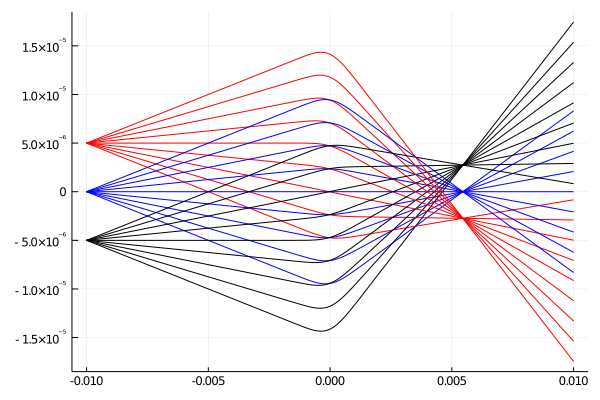

In [25]:
z1 = (zo:1e-4:0.01)
dxo = (-1:0.25:1)*1e-3 
xo = [-1, 0, 1]*5e-6
tcol = ["black","blue","red"]
p=plot()
for i=1:length(dxo)
    for j=1:length(xo)
        plot!(p,z1,xo[j]*g.(z1)+dxo[i]*h.(z1),color=tcol[j],legend=false)
    end
end
plot(p)

Pozice obrazu je daná podmínkou $h(z_i) =0$, proč?

In [26]:
zi = find_zero(h,[0,0.1],Bisection())

0.005452623179240787

(Příčné zvetšení) je pak $M = g(z_i)$, a úhlové zvětšení $M_a=dh(z_i)$

In [27]:
M = g(zi); Ma = dh(zi)
print("M = ", M, "\nMa = ", Ma, "\n")

M = -0.5470826808671513
Ma = -1.8278772665045115


Použití trajektorií $g$ a $h$ je analog přechodových matic, jak je znáte za základního kurzu optiky. Přechodová matice udává zobrazení mezi $z_1$ a $z$, pokud je $z_1=z_o$ je přechodová matice rovna
$$\begin{pmatrix}x(z)\\x^{\prime}(z)\end{pmatrix}=\hat M(z_o,z)\begin{pmatrix}x_o\\x_o^{\prime}\end{pmatrix}$$
$$ \hat M(z_o,z) = \begin{pmatrix}g(z)&h(z)\\g^{\prime}(z)&h^{\prime}(z)\end{pmatrix}$$
v případě zobrazení mezi předmětem a obrazem pak je přechodová matice 
$$\hat M(z_o,z_i) = \begin{pmatrix} M&0\\g^{\prime}(z_i)&M_a\end{pmatrix}$$

Můžeme také nalézt základní charakteristiky čočky, jako jou polohy ohnisek a hlavní roviny. Pro tyto účely je vhodné zavést tzv. **principiální trajektorie**: $u_{\pi}$, která jde z mínus nekonečna s nulovou s měrnicí s osou systému a $u_{\bar\pi}$, která jde z nekonečna s nulovou směrnicí s osou $z$, tj.
\begin{align}
u_{\pi}(-\infty)&=1,& u_{\pi}^{\prime}(-\infty)&=0\\
u_{\bar\pi}(\infty)&=1,& u_{\pi}^{\bar\prime}(\infty)&=0
\end{align}
(Jelikož v našem případě je pole v předmětu zanedbatelné, je dánaprůsečíkem $g(z)$ s osou.) Obrazové ohnisko je dané průsečíkem $u_{\pi}$ s osou a předmětové ohnisko průsečíkem $u_{\bar\pi}$ s osou. Ohniskové dálky jsou pak dané směrnicí těchto paprsků: $\frac 1{f_i} =- u^{\prime}_{\pi}(\infty)$, $\frac 1{f_o} = u^{\prime}_{\bar \pi}(-\infty)$ (vzdálenost od ohniska k rovině, kde se asymptoticky potka prodlouženy paprsek z ohniska s prodlouženym paprskem z nekonečna - pozice hlavni roviny)

zFi = 0.0035102421503962556m 
fi = 0.0035504341423596973m 
zFo = -0.003510242150391164m
fo = 0.003550434142350055m


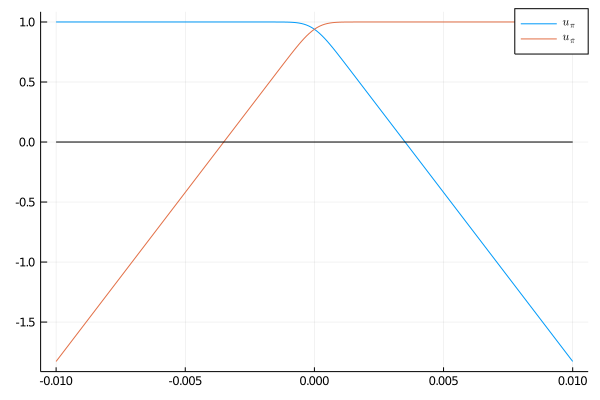

In [28]:
zFi = find_zero(g,[0,0.01],Bisection())
print("zFi = ", zFi,"m \n")
fi = -1/dg(0.1)
print("fi = ", fi,"m \n")
u0=[1,0]; zspan2 = (1e-2,-1e-2)
prob2 = ODEProblem(f2,u0,zspan2)
solbpi = solve(prob2,Tsit5(),reltol=1e-8,abstol=1e-10); 
ubpi = z -> solbpi(z)[1]
dubpi = z -> solbpi(z)[2]
zFo = find_zero(ubpi,[-1e-2,0],Bisection())
fo = 1/dubpi(-0.1)
print("zFo = ", zFo,"m\n")
print("fo = ", fo,"m\n")
gr()
plot(z1,g.(z1),label=L"u_{\pi}")
plot!(z1,ubpi.(z1),label=L"u_{\bar\pi}")
plot!(z1,z1*0,color="black",label=false)

V optice se často používají i jiné báze v prostoru řešení paraxiální rovnice. Význačná je totiž pozice finální apertury $z_a$ - nekdy je vhodné definovat svazek pomoci jeho pozice v předmětu a apertuře. Zavedou se trajektorie $s: s(z_o)=1, s(z_a)=0$, $t: t(z_o)=0, t(z_a)=1$ a libovolný paprsek je pak dostaneme pomoci jeho pozice v předmětu a apertuře ve tvaru:
$$ u(z) = s(z) u_o + t(z) u_a$$
$$ u^{\prime}(z) = s^{\prime}(z) u_o + t^{\prime}(z) u_a$$
$$ u^{\prime}(z_o) = s^{\prime}(z_o) u_o + t^{\prime}(z_o) u_a$$
Trajektorie $s$ a $t$ můžeme lehce spočítat z trajektorií $g$ a $h$. Víme totiž, že $s$ i $t$ jsou lineární kombinace $g$ a $h$:
\begin{align}
s(z) &= ag(z) + bh(z)\\
t(z) &= cg(z) + dh(z)
\end{align}
Pro trajektorii $s$ pak dostaneme:

$1 = s(z_o) = ag(z_o) + bh(z_o) = a$, $0=s(z_a) = g(z_a)+bh(z_a)\Rightarrow b = -\frac{g(z_a)}{h(z_a)}$

a v případě trajektorie $t$:

$0 = t(z_o) = cg(z_o) + dh(z_o) = c$, $1=t(z_a) = dh(z_a)\Rightarrow d = \frac{1}{h(z_a)}$

tedy:
\begin{align}
s(z) &= g(z)-\frac{g(z_a)}{h(z_a)}h(z)\\
t(z) &= \frac{h(z)}{h(z_a)}
\end{align}

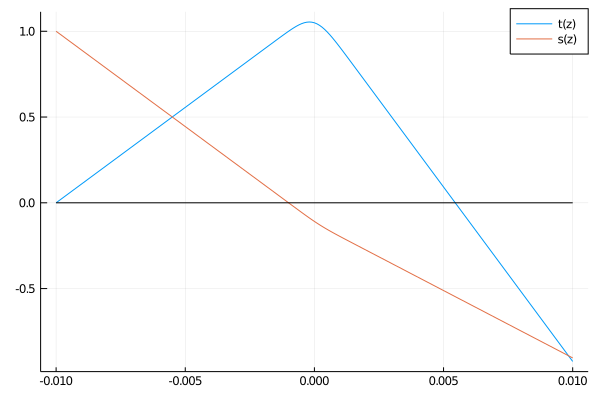

In [29]:
za = -1e-3
s(z) = g(z) -g(za)/h(za)*h(z)
t(z) = h(z)/h(za)
plot(z1,t.(z1),label="t(z)")
plot!(z1,s.(z1),label="s(z)")
plot!(z1,z1*0.0,color="black",label=false)

Ted vykreslime nekolik svazku pomovi této parametrizace ...

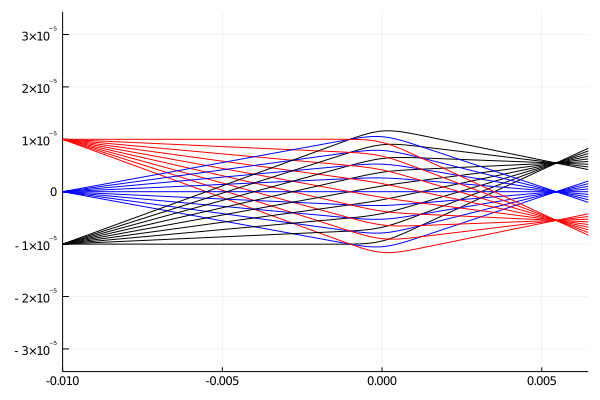

In [30]:
z1 = (zo:1e-4:0.015)
xa = (-1:0.25:1)*1e-5 
xo = [-1, 0, 1]*10e-6
tcol = ["black","blue","red"]
p=plot()
for i=1:length(xa)
    for j=1:length(xo)
        plot!(p,z1,xo[j]*s.(z1)+xa[i]*t.(z1),color=tcol[j],legend=false)
    end
end
xlims!((zo,zi+1e-3))
plot(p)

Pozice v aperture neni zrovna ideální parametr, v elektronové optice je lepší používat úhly. Proto se často místo trajektorie $t$ používá přímo trajektorie $h$, tj. 
$$ u(z) = s(z) u_o + h(z) \alpha_o$$
Jaký je význam úhlu $\alpha_o$?
$$ u^{\prime}(z) = s^{\prime}(z) u_o + h^{\prime}(z) \alpha_o$$
$$ u^{\prime}(z_o) = s^{\prime}(z_o) u_o +  \alpha_o$$
$s(z)u_o$ je paprsek, ktery má v předmětu polohu $u_o$ a protíná osu v rovině apertury. $s^{\prime}(z_o)u_o$ je pak jeho směrnice v předmětu. $\alpha_o$ tedy udává úhlovou odchylku v předmětu dané trajektorie od trajektorie parsku $s(z)u_o$.

Také se často používají trajktorie spojené s rovinou obrazu:
$u_{\alpha}: u_{\alpha}(z_i)=0,\, u^{\prime}_{\alpha}(z_i) = 1$ a $u_{\gamma}: u_{\gamma}(z_i) = 1, u_{\gamma}(z_a) = 0$, pak:
$$u(z) = \gamma u_{\gamma}(z) + \alpha u_{\alpha}(z)$$
jaký je význam $\gamma$ a $\alpha$? Jak získáme $u_{\gamma}(z)$ a $u_{\alpha}(z)$ z trajektorií $s(z)$ a $h(z)$?

## Obecné vlastnosti paraxiálního aproximace
### Wroskian
I bez numerických výpočtů můžeme říct některé základní vlatnosti paraxiální aproximace. Vyjdem z obecné rovnice pro osově symetrický systém v rotačních souřadnicích.
\begin{align}
\newcommand{\dd}{\mathrm{d}}
u^{\prime\prime} + \frac{\gamma\Phi^{\prime}}{2\Phi^*}u^{\prime}+\frac{\gamma\Phi^{\prime\prime}+\eta^2B^2}{4\Phi^*}u=0
\end{align}
Tu lze přepsat do tvaru
\begin{align}
\Phi^{*\frac 12}\frac{\dd}{\dd z}(\Phi^{*\frac 12} u^{\prime})+\left(\frac{\gamma_0}4\Phi^{\prime\prime}+\frac{e}{8m_e}B^2\right)u = 0
\end{align}
Mějme dvě nezávislá řešení $u_1$ a $u_2$, která tvoří bazi vektorového prostoru všech řešení. Můžeme pro ně psát
\begin{align}
\Phi^{*\frac 12}\frac{\dd}{\dd z}(\Phi^{*\frac 12} u_1^{\prime})+\left(\frac{\gamma_0}4\Phi^{\prime\prime}+\frac{e}{8m_e}B^2\right)u_1 =0\\
\Phi^{*\frac 12}\frac{\dd}{\dd z}(\Phi^{*\frac 12} u_2^{\prime})+\left(\frac{\gamma_0}4\Phi^{\prime\prime}+\frac{e}{8m_e}B^2\right)u_2 =0 
\end{align}
Pokud první rovnici vynásobíme $u_2$, druhou rovnici vynásobíme $u_1$ a sečteme, po krátké úpravě dostaneme rovnici 
\begin{align}
\Phi^{*\frac 12}\frac{\dd}{\dd z}\left(\Phi^{*\frac 12}(u_1u_2^{\prime}-u_2u_1^{\prime})\right)=0
\end{align}
která po integraci vede k zákonu zachování Wronskiánu
\begin{align}
W = \Phi^{*\frac12}(u_1u_2^{\prime}-u_2u_1^{\prime}) = \rm{const}
\end{align}
### Lagrange-Helmholtz Relations
V případě báze $g(z)$ a $h(z)$ dostaneme:
\begin{align}
W = \Phi^{*\frac12}(gh^{\prime}-hg^{\prime}) = \Phi^{*\frac12}(z_o)(g(z_o)h^{\prime}(z_o)-h(z_o)g^{\prime}(z_o)) = \Phi^{*\frac12 }(z_i) (g(z_i)h^{\prime}(z_i)-h(z_i)g^{\prime}(z_i))
\end{align}
Což nám určuje vztah mezi úhlovým a příčným zvětšením:
$$\Phi^{*\frac12}(z_o)=\Phi^{*\frac12 }(z_i) MM_a$$
Užitím zákonu zachování Wronskiánu na principiální paprsky a roviny $z=-\infty$, $z=\infty$ dostaneme:
\begin{align}
\Phi_{-\infty}^{*\frac12}\left(u_{\pi}(-\infty)u_{\bar{\pi}}^{\prime}(-\infty)-u_{\bar\pi}(-\infty)u^{\prime}_{\bar\pi}(-\infty)\right)=
\Phi_{\infty}^{*\frac12}\left(u_{\pi}(\infty)u_{\bar{\pi}}^{\prime}(\infty)-u_{\bar\pi}(\infty)u^{\prime}_{\bar\pi}(\infty)\right)
\end{align}
což se využitím definice principiálních trajektoriíredukuje na:
\begin{align}
\Phi_{-\infty}^{*\frac12}u_{\bar{\pi}}^{\prime}(-\infty)=-\Phi_{\infty}^{*\frac12}u_{\pi}^{\prime}(\infty)
\end{align}
Pak dostaneme vztah mezi předmětovou a obrazovou ohniskovou vzdáleností
\begin{align}
\frac{\bar f}f=\sqrt{\frac{\Phi^*_{-\infty}}{\Phi^*_{\infty}}}
\end{align}
V případě námi vypočtené magnetické čočky:

In [31]:
print("M*Ma = ", M*Ma,"\n")
print("fi/f_o = ", fi/fo,"\n")

M*Ma = 0.9999999952554085
fi/f_o = 1.0000000000027158


### Longitudiální zvětšení
Při změně předmětové roviny $z_o \rightarrow z_o+\dd z_o$ se také posune rovina obrazu $z_i\rightarrow z_i+\dd z_i$, pokud je tato změna dostatečně malá, je změna obrazové roviny přímo úměrná změně roviny předmětu, kde konstantu úměrnosti nazýváme longitudiálním zvětšením. Pokud tedy posuneme rovinu předmětu změní se i trajektorie $h \rightarrow \tilde h$. Jelikož se také jedná o řešení paraxiální rovnice trajektorie lze ji psát jako lineární kombinaci původních charakteristických trajektorií
\begin{align}
\tilde h(z) = ah(z)+bg(z)
\end{align}
víme, že trajektorie $\tilde h(z)$ v $z_o+dz_o$ splňuje:
\begin{align}
0&=\tilde h(z_o+dz_o) = ah(z_o+dz_o)+bg(zo+dz_o) =adz_o+b\\
1&=\tilde h^{\prime}(z_o+dz_o) = ah^{\prime}(z_o+dz_o)+bg^{\prime}(z_o+dz_o)=a(h^{\prime}(z_o)+h^{\prime\prime}(z_o)dz_o)+b(g^{\prime}(z_o) + g^{\prime\prime}(z_o)dz_o) = a(1+h^{\prime\prime}(z_o)dz_o)+b(g^{\prime\prime}(z_o)dz_o)
\end{align}
Pokud uvažujeme, že $z_o$ je mimo pole, tak druhé derivace jsou nulové a z druhe rovnice dostaneme $a=1$. Následně pak z první $b=-dz_o$. Trajektorie pak má tvar
$$\tilde h(z) = h(z)-dz_og(z)$$

Pokud vyjádříme tuto trajektorii v novém fokusu
\begin{align}
0=\tilde h(z_i+\dd z_i)=h(z_i+\dd z_i)+\dd z_o g(z_i+\dd z_i)
\end{align}
po rozvoji do mocnin v $\dd z_i$ a zanedbání kvadratických členů v $\dd z_i$ a $\dd z_o$ dostaneme
\begin{align}
\dd z_i = \dd z_o M^2\sqrt{\frac{\Phi_i^*}{\Phi_o^*}}
\end{align}
V případě námi počítané magnetické čočky:

zo = -0.01 m, zo2 = -0.0098 m, dzo = 0.00020000000000000052 m
zi = -0.01:0.0001:0.015 m, zi2 = 0.0055143864785419236 m, dzi = 6.176329930113623e-5 m
dzi_c = 5.985989194095786e-5

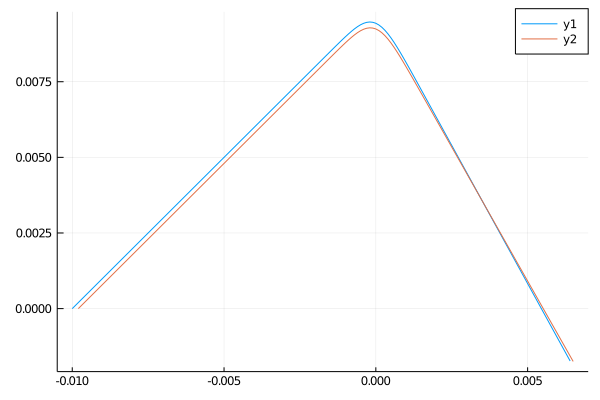

In [32]:
dzo = 2e-4;
zo2 = zo+dzo
zspan = (zo2,1e-2);
u0 = [0,1]#Pocatecni podminky pro trajektorii h
#Vypocet trajektorie h
prob2 = ODEProblem(f2,u0,zspan)
solh2 = solve(prob2,Tsit5(),reltol=1e-8,abstol=1e-10);
h2 = z->solh2(z)[1] #funkce trajektorie h
zi2 = find_zero(h2,[0,0.01],Bisection())
print("zo = ", zo," m, zo2 = ",zo2, " m, dzo = ", zo2-zo," m\n")
print("zi = ", z1," m, zi2 = ",zi2, " m, dzi = ", zi2-zi," m\n")
print("dzi_c = ", M^2*dzo)
z1 = zo:1e-4:zi+1e-3; z2 = zo2:1e-4:zi2+1e-3;
p=plot()
plot!(p,z1,h.(z1))
plot!(p,z2,h2.(z2))
plot(p)

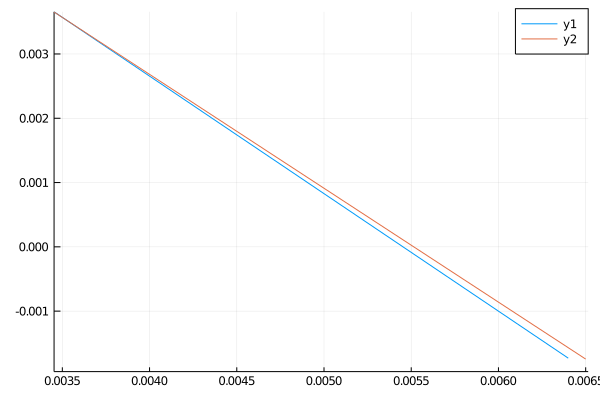

In [34]:
plot(p)
xlims!(zi-2e-3,zi2+1e-3)
ylims!(h(zi2+1e-3),h(zi-2e-3))

### Aproximace tenkou čočkou
V tomto případě zhomogenizovanou rovnici ještě dále upravíme pomoci Pichtovy transformace
\begin{align}
u(z) = \Phi^{*-\frac 14} v(z)
\end{align}
na tvar
\begin{align}
v^{\prime\prime}+G(z)v=0
\end{align}
kde koeficient
\begin{align}
G(z) = \frac 3{16}\frac{\Phi^{\prime 2}}{\Phi^{*2}}\left(1+\frac 43\epsilon\Phi^*\right)+\frac{eB^2}{8m_e\Phi^*}+\frac{\Phi_1\bar\Phi_1}{8\Phi}
\end{align}
je vždy kladný. Předpokládejme, že čočka je tenká, můžeme v ní tedy zanedbat změnu souřadnice $v$, změní se pouze její směrnice
\begin{align}
v^{\prime} = -\int\limits_{-\infty}^{\infty}G(z) v(z) \dd z \approx -v_0\int\limits_{-\infty}^{\infty}G(z) \dd z
\end{align}
pokud tento vztah aplikujeme na principiální paprsky $v_{\pi}$, $v_{\bar\pi}$, použijeme vztah $u = v\Phi^{\ast -1/4}$ a uvážíme že v nekonečnech je osový potenciál konstantní, tj $u_{\pi}^\prime(\infty) = \Phi^{*-1/4}_{\infty}v^\prime_{\pi}(\infty)$, $u_{\bar\pi}^\prime(-\infty) = \Phi^{*-1/4}_{-\infty}v^\prime_{\bar\pi}(-\infty)$ můžeme psát
\begin{align}
v_{\pi}^{\prime}(\infty) = u_{\pi}^{\prime}(\infty) \Phi^{*1/4}_{\infty}= -v_{\pi}(-\infty)\int\limits_{-\infty}^{\infty}G(z) \dd z = -\Phi^{*1/4}_{-\infty} u_{\pi}(-\infty)\int\limits_{-\infty}^{\infty}G(z) \dd z\\
v_{\bar\pi}^{\prime}(-\infty) = u_{\bar\pi}^{\prime}(-\infty) \Phi^{*1/4}_{-\infty}= v_{\bar\pi}(\infty)\int\limits_{-\infty}^{\infty}G(z) \dd z = \Phi^{*1/4}_{\infty} u_{\bar\pi}(\infty)\int\limits_{-\infty}^{\infty}G(z) \dd z
\end{align}
Pro ohniskové dálky pak můžeme psát:
\begin{align}
\frac 1f=\frac{\Phi^{*1/4}_{-\infty}}{\Phi^{*1/4}_{\infty}}\int\limits_{-\infty}^{\infty}G(z) \dd z, \qquad \frac 1{\bar f}=\frac{\Phi^{*1/4}_{\infty}}{\Phi^{*1/4}_{-\infty}}\int\limits_{-\infty}^{\infty}G(z) \dd z,
\end{align}
tedy:
\begin{align}
\frac f{\bar f} = \frac{\Phi^{*1/2}_{\infty}}{\Phi^{*1/2}_{-\infty}}
\end{align}

Pro naši magnetickou čočku vychází:

In [35]:
G(z)=qe*Bax(z)^2/(8*me*Phr)
prob3=ODEProblem((u,p,z)->G(z),0.0,(-0.01,0.01))
iG = solve(prob3,Tsit5(),reltol=1e-8,abstol=1e-10);
fo2 = 1/iG(0.01)
print("Ohniskova vzdalenost z rovnice trajektorie: ", fo,"\n")
print("Ohniskova vzdalenost z aproximace tenkou cockou: ", fo2,"\n")


Ohniskova vzdalenost z rovnice trajektorie: 0.003550434142350055
Ohniskova vzdalenost z aproximace tenkou cockou: 0.0032514106373007713
